# Application of Compressed Gene Expression Signatures

**Gregory Way, 2018**

We previously identified a specific VAE feature (z = 3) that captured blood signatures.
These signatures were not captured in VAE z = 2, and, when present, contributed to a rapid increase in the ability to capture the signal in GTEX blood tissues.

The primary differences between the two VAE models appeared to be related to neutrophil and monocyte signatures. Here, we test the ability of these signatures to generalize to external datasets.


## Part 1:

### Enrichment of Neutrophil Signatures

Here, we apply the VAE feature enriched for neutrophil genes to a publicly available dataset capturing neutrophil differentiation in two leukemia cell lines.

![cell_type_Neutrophils_HPCA_2.png](https://github.com/greenelab/BioBombe/raw/master/6.analyze-weights/figures/GTEX/signal/GpXCELL/gene_set_Neutrophils_HPCA_2.png)

## Part 2:

### Enrichment of Monocyte Signatures

Here, we apply the VAE features enriched for monocyte genes to a different publicly available dataset that captures various cell-types undergoing hematopoiesis.

![cell_type_Monocytes_FANTOM_2.png](https://github.com/greenelab/BioBombe/raw/master/6.analyze-weights/figures/GTEX/signal/GpXCELL/gene_set_Monocytes_FANTOM_2.png)

## Output

In both cases, various scores are output that will be visualized in a separate notebook.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hetio.readwrite
import hetmech.matrix

from scripts.utils import load_weight_matrix, apply_signature, load_enrichment_results

sys.path.append('../scripts')
from latent import parse_gmt

In [2]:
%matplotlib inline

In [3]:
np.random.seed(123)

In [4]:
# First, load the XCELL dataset and extract genes
geneset_file = os.path.join('..', '3.build-hetnets', 'data', 'xcell_all_entrez.gmt')

xcell_genesets_gmt = parse_gmt(gene_sets=[geneset_file])
len(xcell_genesets_gmt)

489

## 1.0. Load and Process External Neutrophil Dataset

In [5]:
file = os.path.join('data', 'GSE103706_processed_matrix.tsv.gz')
geo_scaled_zeroone_df = pd.read_table(file, index_col=0)

print(geo_scaled_zeroone_df.shape)
geo_scaled_zeroone_df.head(2)

(14, 18606)


,1,2,9,12,13,14,15,16,18,19,...,105371242,105373377,105375205,105377595,105379554,106821730,107282092,107984155,107984923,107987479
"HL-60, DMSO+Nutridoma, day 6, replicate 1",0.928066,1.000000,0.131285,0.0,0.0,0.258895,0.0,0.097450,0.899518,1.000000,...,0.0,0.0,0.456063,0.0,0.230915,0.000000e+00,0.161967,0.0,0.233555,0.280561
"HL-60, DMSO+Nutridoma, day 6, replicate 2",0.520178,0.782566,0.217753,0.0,0.0,0.000000,1.0,0.016712,0.321479,0.622087,...,0.0,0.0,0.263193,0.0,0.000015,5.445048e-210,0.231850,0.0,0.266596,0.163936


## 1.1. Apply Signature from VAE z = 3 (feature 0)

We are using feature 0 from VAE z = 3 because we previously observed an enrichment of a Neutrophil signature in this specific feature.

In [6]:
vae_z3_seed = 908341
vae_z3_feature = 'vae_0'

In [7]:
weight_z3_df = load_weight_matrix(dataset='GTEX',
                                  z_dim=3,
                                  seed=vae_z3_seed)

result_vae_3_feat0, neutrophil_missing_genes = (
    apply_signature(weight_df=weight_z3_df,
                    other_df=geo_scaled_zeroone_df,
                    feature=vae_z3_feature,
                    align=True)
)

print('{}% of genes are missing'.format(len(neutrophil_missing_genes) / weight_z3_df.shape[0] * 100 ))

4.2% of genes are missing


In [8]:
neutrophil_hpca_genes = xcell_genesets_gmt['Neutrophils_HPCA_2']
neutrophil_hpca_genes

['1441', '54210', '53829', '2215', '6283', '3310', '2358', '3579']

In [9]:
# But how many of the missing genes belong to the specific Neutrophil signature
[x for x in neutrophil_hpca_genes if int(x) in neutrophil_missing_genes]

[]

## 1.2. Apply Signature from VAE z = 14 (feature 10)

We are using VAE z = 14 because, for some reason, this dimension was best able to capture the `Neutrophil_HPCA_2` xCell geneset.
This geneset was the same geneset that was enriched in feature 0 for VAE z = 3.

We identified feature 10 as the feature with the greatest enrichment by visually scanning the biobombe results in `results/gtex/gpxcell/signal/gtex_z_14_GpXCELL__geneset_scores.tsv`

In [10]:
z_14_df = load_enrichment_results(dataset="GTEX",
                                  metaedge="GpXCELL",
                                  z_dim=14)

z_14_df = (
    z_14_df
    .query("variable == 'Neutrophils_HPCA_2'")
    .assign(abs_z_score=z_14_df.z_score.abs())
    .sort_values(by='abs_z_score', ascending=False)
)

z_14_df.head(1)

,model_type,variable,value,z_score,algorithm,feature,z,seed,abs_z_score
15,real,Neutrophils_HPCA_2,-1.22986,-30.0841,vae,10,14,486191,30.0841


In [11]:
vae_z14_seed = z_14_df.head(1).seed.values[0]
vae_z14_feature = '{}_{}'.format(z_14_df.head(1).algorithm.values[0],
                                 z_14_df.head(1).feature.values[0])

print(vae_z14_seed)
vae_z14_feature

486191


'vae_10'

In [12]:
weight_z14_df = load_weight_matrix(dataset='GTEX',
                                   z_dim=14,
                                   seed=vae_z14_seed)

result_vae_14_feat10, _ = apply_signature(weight_df=weight_z14_df,
                                          other_df=geo_scaled_zeroone_df,
                                          feature=vae_z14_feature,
                                          align=True)

## 1.3. Combine Data and Add Phenotype Information

In [13]:
full_neutrophil_results_df = result_vae_14_feat10.merge(result_vae_3_feat0,
                                                        left_index=True,
                                                        right_index=True)

In [14]:
# Process phenotype data
cell_line = [x[0] for x in result_vae_3_feat0.index.str.split(',')]
treatment = [x[1] for x in result_vae_3_feat0.index.str.split(',')]
day = [x[2].strip(' ') if 'replicate' not in x[2] else 'day 0'
       for x in result_vae_3_feat0.index.str.split(',')]

In [15]:
full_neutrophil_results_df = (
    full_neutrophil_results_df
    .assign(cell_line=cell_line,
            treatment=treatment,
            day=day)
    .reset_index()
    .rename(columns={'index': 'full_id'})
)

recode_labels = {' not differentiated': 'Not Differentiated',
                 ' DMSO': 'DMSO',
                 ' DMSO+Nutridoma': 'DMSO+Nutridoma'}

full_neutrophil_results_df.treatment = full_neutrophil_results_df.treatment.replace(recode_labels)

file = os.path.join('results', 'neutrophil_data_biobombe_results.tsv')
full_neutrophil_results_df.to_csv(file, index=False, sep='\t')

full_neutrophil_results_df

,full_id,vae_10,vae_0,cell_line,treatment,day
0,"HL-60, DMSO+Nutridoma, day 6, replicate 1",-36.049434,-143.876272,HL-60,DMSO+Nutridoma,day 6
1,"HL-60, DMSO+Nutridoma, day 6, replicate 2",-22.590977,-106.286791,HL-60,DMSO+Nutridoma,day 6
2,"HL-60, DMSO, day 6, replicate 1",-35.909924,-156.422128,HL-60,DMSO,day 6
3,"HL-60, DMSO, day 6, replicate 2",-39.231079,-117.157236,HL-60,DMSO,day 6
4,"HL-60, not differentiated, replicate 1",4.608596,-164.379558,HL-60,Not Differentiated,day 0
5,"HL-60, not differentiated, replicate 2",20.108394,-130.046084,HL-60,Not Differentiated,day 0
6,"PLB-985, DMSO+Nutridoma, day 2",-16.096259,-135.552338,PLB-985,DMSO+Nutridoma,day 2
7,"PLB-985, DMSO+Nutridoma, day 4",-28.350487,-162.160578,PLB-985,DMSO+Nutridoma,day 4
8,"PLB-985, DMSO+Nutridoma, day 6, replicate 1",-35.254016,-152.617394,PLB-985,DMSO+Nutridoma,day 6
9,"PLB-985, DMSO+Nutridoma, day 6, replicate 2",-23.895784,-130.494257,PLB-985,DMSO+Nutridoma,day 6


## 1.4. Quickly Visualize Signature Applied to External Dataset

Note the final figure is compiled in an alternative notebook

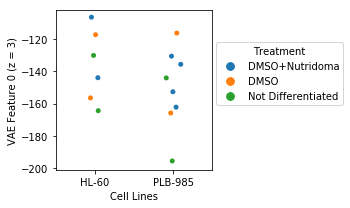

In [16]:
# Quickly visualize results
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(x='cell_line',
                   y='vae_0',
                   data=full_neutrophil_results_df,
                   hue='treatment',
                   jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8),
               loc=2,
               borderaxespad=0.)
l.set_title("Treatment")

ax.set_ylabel('VAE Feature 0 (z = 3)')
ax.set_xlabel('Cell Lines')

plt.tight_layout()

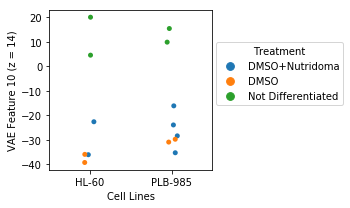

In [17]:
# Quickly visualize results
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(x='cell_line',
                   y='vae_10',
                   data=full_neutrophil_results_df,
                   hue='treatment',
                   jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8),
               loc=2,
               borderaxespad=0.)
l.set_title("Treatment")

ax.set_ylabel('VAE Feature 10 (z = 14)')
ax.set_xlabel('Cell Lines')

plt.tight_layout()

## 1.5. Compare the two signatures derived from both models

Use the function `load_enrichment_results` to retrieve and subset previously compiled BioBombe results.
The files are located in `6.analyze-weights/results/`.

In [18]:
# What other genesets are enriched in VAE z = 3 feature?
vae_z3_p0 = load_enrichment_results(dataset='GTEX',
                                    z_dim=3,
                                    metaedge='GpXCELL',
                                    algorithm='vae',
                                    feature=0,
                                    seed=vae_z3_seed,
                                    shuffled=False)

# What other genesets are enriched in VAE z = 14 feature?
vae_z14_p10 = load_enrichment_results(dataset='GTEX',
                                      z_dim=14,
                                      metaedge='GpXCELL',
                                      algorithm='vae',
                                      feature=10,
                                      seed=vae_z14_seed,
                                      shuffled=False)

full_test_df = vae_z3_p0.merge(vae_z14_p10, on='variable', suffixes=('_z3', '_z14'))

file = os.path.join('results', 'latent_feature_enrichment_comparison_neutrophil_genesets.tsv')
full_test_df.to_csv(file, index=False, sep='\t')

full_test_df.head(3)

,model_type_z3,variable,value_z3,z_score_z3,algorithm_z3,feature_z3,z_z3,seed_z3,model_type_z14,value_z14,z_score_z14,algorithm_z14,feature_z14,z_z14,seed_z14
0,real,Keratinocytes_HPCA_3,-10.9015,-33.32250,vae,2,3,908341,real,-2.46113,-5.42071,vae,10,14,486191
1,real,Keratinocytes_HPCA_3,-11.9194,-19.00490,vae,1,3,908341,real,-2.46113,-5.42071,vae,10,14,486191
2,real,Keratinocytes_HPCA_3,1.3954,5.91483,vae,0,3,908341,real,-2.46113,-5.42071,vae,10,14,486191


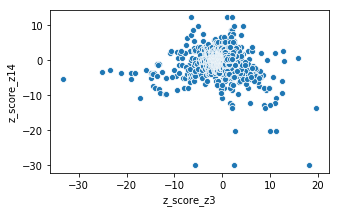

In [19]:
# Save dataframe for better plotting in R, but visualize quickly here
sns.scatterplot(data=full_test_df, x='z_score_z3', y='z_score_z14');

### 1.5.1 Determine Gene Weights across the Two Features

Also assign labels to which genesets the genes contribute to

In [20]:
unique_genes = []
for geneset_name, geneset in xcell_genesets_gmt.items():
    for gene in geneset:
        unique_genes.append(gene)

unique_genes = set(unique_genes)

classification_genes = []
for geneset_name, geneset in xcell_genesets_gmt.items():
    if 'neutrophil' in geneset_name.lower():
        classification = 'Neutrophils'
    elif 'keratinocytes' in geneset_name.lower():
        classification = 'Keratinocytes'
    elif 'neurons' in geneset_name.lower():
        classification = 'Neurons'
    elif 'skeletal' in geneset_name.lower():
        classification = 'Skeletal Muscle'
    elif 'monocytes' in geneset_name.lower():
        classification = 'Monocytes'
    else:
        classification = 'Other Geneset'
    for gene in geneset:
        if gene in weight_z14_df.index:
            classification_genes.append([classification, gene, geneset_name])

In [21]:
result_df = (
    pd.DataFrame(classification_genes, columns=['classification', 'gene', 'gene_set'])
    .sort_values(by='classification')
    .reset_index(drop=True)
    .drop_duplicates(subset='gene', keep='first')
)

result_df.gene = result_df.gene.astype(str)
result_df.index = result_df.gene
result_df.head()

,classification,gene,gene_set
gene,,,
3872,Keratinocytes,3872,Keratinocytes_FANTOM_1
6665,Keratinocytes,6665,Keratinocytes_HPCA_2
8581,Keratinocytes,8581,Keratinocytes_HPCA_2
3714,Keratinocytes,3714,Keratinocytes_HPCA_2
6653,Keratinocytes,6653,Keratinocytes_FANTOM_1


In [22]:
result_df.classification.value_counts()

Other Geneset      2250
Monocytes           202
Neurons             169
Keratinocytes        90
Neutrophils          27
Skeletal Muscle      13
Name: classification, dtype: int64

In [23]:
both_weight_df = (
    weight_z3_df.merge(weight_z14_df,
                       left_index=True,
                       right_index=True,
                       suffixes=('_3', '_14'))
    .merge(result_df, left_index=True,
           right_index=True, how='left')
    .fillna('No Geneset')
)

file = os.path.join('results', 'latent_feature_enrichment_comparison_neutrophil_genes.tsv')
both_weight_df.to_csv(file, index=False, sep='\t')

## 2.0. Load and Process External Hematopoietic Dataset

In [24]:
file = os.path.join('data', 'GSE24759_processed_matrix.tsv.gz')
heme_zeroone_df = pd.read_table(file, index_col=0)

print(heme_zeroone_df.shape)
heme_zeroone_df.head(2)

(211, 8190)


,2,9,14,16,18,19,20,22,23,25,...,100137049,100462977,100505741,100507436,100527963,100652748,102723547,105369230,107984923,107987479
BASO1_3,0.389491,0.342512,0.173372,0.196964,0.431818,0.405355,0.200679,0.580138,0.457497,0.475122,...,0.150598,0.297524,0.83302,0.410220,0.379413,0.271206,0.467457,0.842266,0.441286,0.384583
BASO1_4,0.308525,0.233696,0.281117,0.385034,0.540101,0.317294,0.262179,0.688354,0.453625,0.586759,...,0.268785,0.490944,0.77053,0.495008,0.660851,0.329928,0.365230,0.923228,0.487514,0.371348


In [25]:
heme_z3_seed = 908341
heme_z3_feature = 'vae_2'

In [26]:
# Transform the external dataset with this learned feature
weight_heme_z3_df = load_weight_matrix(dataset='GTEX',
                                       z_dim=3,
                                       seed=heme_z3_seed)

result_heme_vae_3_feat2, monocyte_missing_genes = (
    apply_signature(weight_df=weight_heme_z3_df,
                    other_df=heme_zeroone_df,
                    feature=heme_z3_feature,
                    align=True)
)

print('{}% of genes are missing'.format(len(monocyte_missing_genes) / weight_heme_z3_df.shape[0] * 100 ))

41.9375% of genes are missing


In [27]:
monocyte_fantom_genes = xcell_genesets_gmt['Monocytes_FANTOM_2']
monocyte_fantom_genes

['1536',
 '10241',
 '3587',
 '11277',
 '23569',
 '23064',
 '4123',
 '3614',
 '4140',
 '27180',
 '10287',
 '10288',
 '204851',
 '9784',
 '79930',
 '1089',
 '53829',
 '10313',
 '11337',
 '5199',
 '4689',
 '51284',
 '9815',
 '23135',
 '5728',
 '27235',
 '51304',
 '5739',
 '10859',
 '51311',
 '2162',
 '9332',
 '4215',
 '10871',
 '23673',
 '26234',
 '1659',
 '58488',
 '23166',
 '8834',
 '6787',
 '6277',
 '6281',
 '6283',
 '26253',
 '729230',
 '124565',
 '10390',
 '27287',
 '7321',
 '80025',
 '2204',
 '137886',
 '671',
 '2207',
 '55968',
 '50856',
 '2219',
 '64174',
 '79026',
 '54453',
 '9398',
 '695',
 '29888',
 '8897',
 '706',
 '3267',
 '3779',
 '25796',
 '79042',
 '199',
 '4296',
 '719',
 '7375',
 '23765',
 '2268',
 '10462',
 '79587',
 '9444',
 '9958',
 '64231',
 '9450',
 '5355',
 '4332',
 '23276',
 '3310',
 '4335',
 '55023',
 '353514',
 '9470',
 '23294',
 '7940',
 '23304',
 '23309',
 '7439',
 '11024',
 '11025',
 '64783',
 '11027',
 '23317',
 '5914',
 '23325',
 '7454',
 '79143',
 '29992',

In [28]:
# But how many of the missing genes belong to the specific Monocyte signature
monocyte_signature_genes_missing = [x for x in monocyte_fantom_genes if int(x) in monocyte_missing_genes]
monocyte_signature_genes_missing

['79930',
 '5739',
 '124565',
 '29888',
 '11025',
 '11054',
 '23387',
 '22895',
 '7123',
 '8685']

In [29]:
print('{:.2f}% of monocyte genes are missing'.format(len(monocyte_signature_genes_missing) / len(monocyte_fantom_genes) * 100 ))

5.62% of monocyte genes are missing


In [30]:
# Additionall, the top scoring feature for Monocytes_FANTOM_2 is in the nmf model with 200 features
file = os.path.join('..', '6.analyze-weights', 'results', 'gtex',
                    'gpxcell', 'signal',
                    'gtex_z_200_GpXCELL__geneset_scores.tsv.gz')

gtex_z200_scores_df = (
    pd.read_table(file)
    .query('variable == "Monocytes_FANTOM_2"'))

gtex_z200_scores_df = (
    gtex_z200_scores_df
    .assign(abs_z_score = gtex_z200_scores_df.z_score.abs())
    .sort_values(by='abs_z_score', ascending=False)
    .head(1)
)

gtex_z200_scores_df

,model_type,variable,value,z_score,algorithm,feature,z,seed,abs_z_score
2444895,real,Monocytes_FANTOM_2,37.7563,31.9881,nmf,6,200,908341,31.9881


In [31]:
heme_z200_feature = '{}_{}'.format(gtex_z200_scores_df.algorithm.values[0],
                                   gtex_z200_scores_df.feature.values[0])

heme_z200_feature

'nmf_6'

In [ ]:
# Obtain this transformation too
weight_heme_z200_df = load_weight_matrix(dataset='GTEX',
                                         z_dim=200,
                                         seed=gtex_z200_scores_df.seed.values[0])


result_heme_nmf_200_feat6, _ = apply_signature(weight_df=weight_heme_z200_df,
                                            other_df=heme_zeroone_df,
                                            feature=heme_z200_feature,
                                            align=True)

In [ ]:
# Combine the full scores and output for downstream visualization
full_heme_result_df = (
    result_heme_vae_3_feat2
    .merge(result_heme_nmf_200_feat6, left_index=True, right_index=True)
    .reset_index().rename(columns={'index': 'cell'})
)

In [ ]:
heme_cell_type_recode_df = (
    pd.DataFrame(full_heme_result_df.cell.str.split('_').values.tolist(),
                 columns = ['cell_type', 'replicate', 'additional'])
)

heme_cell_type_recode_df.loc[~heme_cell_type_recode_df.additional.isna(), 'cell_type'] = "PRE_BCELL2"

In [ ]:
full_heme_result_df = (
    pd.concat([heme_cell_type_recode_df.drop(['additional'], axis='columns'),
               full_heme_result_df], axis='columns')
)

In [ ]:
# Recode cell-type into larger classification
file = os.path.join('results', 'cell-type-classification.tsv')
cell_class_df = pd.read_table(file)

cell_updater = dict(zip(cell_class_df.label, cell_class_df.classification))

cell_class_df.head()

In [ ]:
full_heme_result_df = (
    full_heme_result_df
    .assign(cell_class = full_heme_result_df.cell_type.replace(cell_updater))
)

file = os.path.join('results', 'hematopoietic_data_biobombe_results.tsv')
full_heme_result_df.to_csv(file, index=False, sep='\t')

full_heme_result_df.head()

In [ ]:
# Quickly plot results for both features
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(y='vae_2', x = 'cell_class', data = full_heme_result_df, hue = 'cell_class', jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8), loc=2, borderaxespad=0.)


In [ ]:
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.stripplot(y='nmf_6', x = 'cell_class', data = full_heme_result_df, hue = 'cell_class', jitter=0.1)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles,
               labels,
               bbox_to_anchor=(1.02, 0.8), loc=2, borderaxespad=0.)